# Categorical EDA (Karim) - простой рабочий ноутбук

Запускай ячейки сверху вниз. Если ловишь редкую ошибку `pandas.period already defined`,
перезапусти Kernel и снова Run All.


In [28]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from pyarrow.lib import ArrowKeyError
import pyarrow as pa

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, kruskal
from sklearn.feature_selection import mutual_info_classif

sns.set_theme(style='whitegrid')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


In [29]:
REPO_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_DIR = os.path.join(REPO_ROOT, 'src' , 'data')
OUT_DIR = os.path.join(REPO_ROOT, 'outputs', 'categorical_analysis')

LABELS_PATH = os.path.join(DATA_DIR, 'train_labels.parquet')

PRETRAIN_FILES = [
    os.path.join(DATA_DIR,'pretrain_part_1.parquet'),
    os.path.join(DATA_DIR,'pretrain_part_2.parquet'),
    os.path.join(DATA_DIR,'pretrain_part_3.parquet'),
]
TRAIN_FILES = [
    os.path.join(DATA_DIR,'train_part_1.parquet'),
    os.path.join(DATA_DIR,'train_part_2.parquet'),
    os.path.join(DATA_DIR,'train_part_3.parquet'),
]


print(f'Project root: {REPO_ROOT}')
print('LABELS_PATH:', LABELS_PATH)
print('TRAIN FILES:')
for x in TRAIN_FILES:
    print('\t-', x)
print('PRETRAIN FILES:')
for x in PRETRAIN_FILES:
    print('\t-', x)


Project root: /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest
LABELS_PATH: /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_labels.parquet
TRAIN FILES:
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_part_1.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_part_2.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/train_part_3.parquet
PRETRAIN FILES:
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/pretrain_part_1.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/pretrain_part_2.parquet
	- /Users/karimkhabib/Documents/Projects Programming/PyCharm/data-fusion-contest/src/data/pretrain_part_3.parquet


# Read Train Labels

In [30]:
labels = pd.read_parquet(LABELS_PATH)
labels.head(10)

,customer_id,event_id,target
0,123123123123129,124093788813382,0
1,123123123123138,126035112904381,0
2,123123123123169,124325714018852,1
3,123123123123169,124944191029616,1
4,123123123123169,126395888234936,1
5,123123123123212,125932035614428,1
6,123123123123244,126000752300936,0
7,123123123123244,126413069904279,0
8,123123123123252,123131714049918,1
9,123123123123252,124875471589677,1


In [31]:
labels.info(), len(labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87514 entries, 0 to 87513
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  87514 non-null  int64
 1   event_id     87514 non-null  int64
 2   target       87514 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 1.7 MB


(None, 87514)

# Reading Train 1

In [32]:
train_df_1 = pd.read_parquet(TRAIN_FILES[0])
train_df_1.head(10)

,customer_id,event_id,event_dttm,event_type_nm,event_desc,channel_indicator_type,channel_indicator_sub_type,operaton_amt,currency_iso_cd,mcc_code,pos_cd,accept_language,browser_language,timezone,session_id,operating_system_type,battery,device_system_version,screen_size,developer_tools,phone_voip_call_state,web_rdp_connection,compromised
0,123123123123129,123999300382879,2024-10-01 05:29:14,14,75,6,5,56422.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
1,123123123123129,124531875713936,2024-10-01 10:17:22,7,56,4,15,NaN,NaN,None,NaN,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
2,123123123123129,123329285580171,2024-10-01 10:20:03,3,120,6,5,300870.0,0.0,10,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
3,123123123123129,124334305430665,2024-10-02 07:48:09,14,75,6,5,298458.0,0.0,1,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
4,123123123123129,126215501146513,2024-10-02 11:20:40,14,75,6,5,59944.0,0.0,15,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
5,123123123123129,126464610203810,2024-10-02 17:22:44,14,75,6,5,137235.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
6,123123123123129,125502539036271,2024-10-03 18:24:36,14,75,6,5,107159.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
7,123123123123129,123904810425848,2024-10-04 18:21:22,14,75,6,5,29388.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
8,123123123123129,126198323368888,2024-10-07 12:33:21,14,75,0,5,89946.0,0.0,15,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None
9,123123123123129,123269153919321,2024-10-07 18:32:20,14,75,0,5,218215.0,0.0,4,3.0,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,None


In [33]:
for c in train_df_1.columns:
    print(c, train_df_1[c].dtype, train_df_1[c].nunique(dropna=False))

customer_id int64 33333
event_id int64 28618594
event_dttm object 13374722
event_type_nm int32 17
event_desc int32 143
channel_indicator_type int32 7
channel_indicator_sub_type int32 16
operaton_amt float64 1094899
currency_iso_cd float64 20
mcc_code object 21
pos_cd float64 23
accept_language object 375
browser_language object 22
timezone float64 104
session_id float64 11823077
operating_system_type float64 12
battery object 118
device_system_version object 117
screen_size object 1523
developer_tools object 3
phone_voip_call_state float64 3
web_rdp_connection float64 3
compromised object 3


In [34]:
CATEGORICAL_COLUMNS = [
    'customer_id', 'event_id', 'session_id', # <---- Common feature Нельзя удалять тк обращаемся по ним!
    'pos_cd',
    'accept_language',
    'browser_language',
    'operating_system_type',
    'developer_tools',
    'phone_voip_call_state',
    'web_rdp_connection',
    'compromised',
    'timezone'
]
for col in CATEGORICAL_COLUMNS:
    print(f'{col}: {col in list(train_df_1.columns)}')
train_df_1 = train_df_1[CATEGORICAL_COLUMNS]
train_df_1.head()

customer_id: True
event_id: True
session_id: True
pos_cd: True
accept_language: True
browser_language: True
operating_system_type: True
developer_tools: True
phone_voip_call_state: True
web_rdp_connection: True
compromised: True
timezone: True


,customer_id,event_id,session_id,pos_cd,accept_language,browser_language,operating_system_type,developer_tools,phone_voip_call_state,web_rdp_connection,compromised,timezone
0,123123123123129,123999300382879,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN
1,123123123123129,124531875713936,NaN,NaN,None,None,NaN,None,NaN,NaN,None,NaN
2,123123123123129,123329285580171,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN
3,123123123123129,124334305430665,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN
4,123123123123129,126215501146513,NaN,3.0,None,None,NaN,None,NaN,NaN,None,NaN


In [35]:
stats_df = pd.DataFrame({
    'missing_count': train_df_1.isna().sum(),
    'missing_rate': train_df_1.isna().sum() / len(train_df_1),
    'remaining_data': len(train_df_1) - train_df_1.isna().sum()
})
stats_df

,missing_count,missing_rate,remaining_data
customer_id,0,0.000000,28618594
event_id,0,0.000000,28618594
session_id,11400983,0.398377,17217611
pos_cd,26134680,0.913206,2483914
accept_language,25452822,0.889381,3165772
browser_language,25968210,0.907389,2650384
operating_system_type,25917436,0.905615,2701158
developer_tools,19888868,0.694963,8729726
phone_voip_call_state,22639583,0.791079,5979011
web_rdp_connection,24055569,0.840557,4563025


In [36]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28618594 entries, 0 to 28618593
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   customer_id            int64  
 1   event_id               int64  
 2   session_id             float64
 3   pos_cd                 float64
 4   accept_language        object 
 5   browser_language       object 
 6   operating_system_type  float64
 7   developer_tools        object 
 8   phone_voip_call_state  float64
 9   web_rdp_connection     float64
 10  compromised            object 
 11  timezone               float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.6+ GB


## Object Types

In [37]:
train_df_1['accept_language'].value_counts()

accept_language
ru                                                          2596882
ru-ru                                                        361905
ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7                          133580
ru,en;q=0.9                                                   16963
en-gb                                                         12210
                                                             ...   
en,ru;q=0.9,en-US;q=0.8,ru-RU;q=0.7,fi;q=0.6                      1
ru,en-US;q=0.9,en;q=0.8,sq;q=0.7                                  1
ru,en-US;q=0.9,en;q=0.8,fa;q=0.7                                  1
de-DE,de;q=0.9,ru-RU;q=0.8,ru;q=0.7,en-US;q=0.6,en;q=0.5          1
ru-RU,ru;q=0.9,fr-TN;q=0.8,fr;q=0.7,en-US;q=0.6,en;q=0.5          1
Name: count, Length: 374, dtype: int64

In [38]:
# def clean_accept_language(x) -> str:
#     if not x or x == '__MISSING__': return '__MISSING__'
#     if x[:2] in ['zh','*','ru', 'en']:return x[:2]
# 
# train_df_1['accept_language'] = train_df_1['accept_language'].apply(clean_accept_language)
# train_df_1['accept_language'].value_counts()

In [39]:
# def clean_browser_language(x) -> str:
#     if not x or x == '__MISSING__': return '__MISSING__'
#     return 'not available'
# train_df_1['browser_language'] = train_df_1['browser_language'].apply(clean_browser_language)
# train_df_1['browser_language'].value_counts()

In [40]:
train_df_1['developer_tools'] = train_df_1['developer_tools'].astype('Int64')
train_df_1['developer_tools'].value_counts()

developer_tools
0    7282484
1    1447242
Name: count, dtype: Int64

In [41]:
train_df_1['compromised'] = train_df_1['compromised'].astype('Int64')
train_df_1['compromised'].value_counts()

compromised
0    12927568
1       17587
Name: count, dtype: Int64

In [56]:
train_df_1['timezone'].value_counts()

timezone
31.0      1749293
13.0       339162
21.0        81098
27.0        76727
16.0        63107
33.0        62534
10.0        58958
0.0         50859
42.0        34614
18.0        34513
38.0        26927
3.0         23193
26.0        22525
8.0         20446
2.0         15096
32.0        13635
28.0        12940
25.0         9152
36.0         7607
12.0         6855
15.0         6055
20.0         5860
14.0         4449
19.0         3731
23.0         3729
29.0         3366
1.0          3267
9.0          1820
39.0         1510
4.0          1063
37.0          981
34.0          838
24.0          813
17.0          622
11.0          467
52.0          354
48.0          307
40.0          279
7.0           262
35.0          239
41.0          214
30.0          162
43.0          143
5.0           139
6.0           135
66.0          108
67.0           67
50.0           63
47.0           62
76.0           36
84.0           32
46.0           25
45.0           19
55.0           16
70.0           14
2

In [42]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28618594 entries, 0 to 28618593
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   customer_id            int64  
 1   event_id               int64  
 2   session_id             float64
 3   pos_cd                 float64
 4   accept_language        object 
 5   browser_language       object 
 6   operating_system_type  float64
 7   developer_tools        Int64  
 8   phone_voip_call_state  float64
 9   web_rdp_connection     float64
 10  compromised            Int64  
 11  timezone               float64
dtypes: Int64(2), float64(6), int64(2), object(2)
memory usage: 2.6+ GB


# Reading Train 2

In [43]:
# train_df_2 = pd.read_parquet(TRAIN_FILES[1])
# train_df_2 = train_df_2[CATEGORICAL_COLUMNS]
# train_df_2.head(10)

# Check Features

In [44]:
labels.head()

,customer_id,event_id,target
0,123123123123129,124093788813382,0
1,123123123123138,126035112904381,0
2,123123123123169,124325714018852,1
3,123123123123169,124944191029616,1
4,123123123123169,126395888234936,1


In [45]:
cat_cols = [
    'pos_cd','accept_language','browser_language','operating_system_type',
    'developer_tools','phone_voip_call_state','web_rdp_connection','compromised','timezone'
]

In [50]:
train_df_1["event_id"] = pd.to_numeric(train_df_1["event_id"], errors="coerce").astype("Int64")
labels["event_id"] = pd.to_numeric(labels["event_id"], errors="coerce").astype("Int64")

In [46]:
# CELL 1 — labels + merge (почему 87514 vs 28.6M)
# 87514 — это размеченные события (red/yellow),
# 28.6M — все события train.
# Для антифрода делаем бинарный target: 1 = red, 0 = все остальные (в т.ч. unlabeled).

df = train_df_1.merge(labels[["event_id", "target"]], on="event_id", how="left")
df["target_bin"] = np.where(df["target"].eq(1), 1, 0).astype("int8")

print("rows:", len(df))
print("matched labels:", df["target"].notna().sum())
print("positives total:", int(df["target_bin"].sum()))
print(df["target_bin"].value_counts())


train rows: 28618594
labels rows: 87514
merged rows: 28618594
positive rate: 0.000607


In [47]:
# df.head()

,customer_id_x,event_id,session_id,pos_cd,accept_language,browser_language,operating_system_type,developer_tools,phone_voip_call_state,web_rdp_connection,compromised,timezone,customer_id_y,target,target_bin
0,123123123123129,123999300382879,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
1,123123123123129,124531875713936,NaN,NaN,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
2,123123123123129,123329285580171,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
3,123123123123129,124334305430665,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0
4,123123123123129,126215501146513,NaN,3.0,None,None,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,0


In [48]:
# X = df[cat_cols].copy()
# for c in cat_cols:
#     X[c] = X[c].astype("string").fillna("__MISSING__").astype(str)
# 
# y = df['target_bin'].values

In [51]:
# CELL B — безопасный split для CatBoost (для EDA важности лучше только labeled)
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score


work = df[df["target"].notna()].copy()  # важно: только размеченные для анализа влияния
X = work[cat_cols].copy()
for c in cat_cols:
    X[c] = X[c].astype("string").fillna("__MISSING__").astype(str)

y = np.where(work["target"].eq(1), 1, 0).astype("int8")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("train positives:", int(y_train.sum()), "val positives:", int(y_val.sum()))

model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="PRAUC",
    iterations=500,
    depth=8,
    learning_rate=0.05,
    auto_class_weights="Balanced",
    verbose=100
)
model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_val, y_val), use_best_model=True)

pred = model.predict_proba(X_val)[:, 1]
print("AP:", average_precision_score(y_val, pred))


train positives: 13907 val positives: 3477
0:	learn: 0.6686646	test: 0.6700652	best: 0.6700652 (0)	total: 25.1ms	remaining: 12.5s
100:	learn: 0.6871751	test: 0.6768468	best: 0.6773561 (45)	total: 1.27s	remaining: 5s
200:	learn: 0.6896240	test: 0.6755166	best: 0.6773561 (45)	total: 2.61s	remaining: 3.89s
300:	learn: 0.6941186	test: 0.6756218	best: 0.6773561 (45)	total: 4.02s	remaining: 2.66s
400:	learn: 0.6970795	test: 0.6742090	best: 0.6773561 (45)	total: 5.52s	remaining: 1.36s
499:	learn: 0.6998968	test: 0.6734282	best: 0.6773561 (45)	total: 7.02s	remaining: 0us

bestTest = 0.6773560727
bestIteration = 45

Shrink model to first 46 iterations.
AP: 0.7243447844268102


In [52]:
# 1) Важность по модели
fi = pd.DataFrame({
    "feature": cat_cols,
    "fi": model.get_feature_importance(type="FeatureImportance")
}).sort_values("fi", ascending=False)

display(fi)


,feature,fi
0,pos_cd,44.456061
5,phone_voip_call_state,18.083395
1,accept_language,11.478812
2,browser_language,7.536629
3,operating_system_type,7.143580
4,developer_tools,3.883363
8,timezone,3.306835
6,web_rdp_connection,2.937429
7,compromised,1.173896


In [53]:

from sklearn.metrics import average_precision_score

base_ap = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])

rows = []
rng = np.random.default_rng(42)

for col in cat_cols:
    Xp = X_val.copy()
    Xp[col] = rng.permutation(Xp[col].values)
    ap = average_precision_score(y_val, model.predict_proba(Xp)[:, 1])
    rows.append({"feature": col, "ap_drop": base_ap - ap})

perm = pd.DataFrame(rows).sort_values("ap_drop", ascending=False)
display(perm)
print("base_ap:", base_ap)


,feature,ap_drop
0,pos_cd,0.052120
4,developer_tools,0.050948
5,phone_voip_call_state,0.023405
1,accept_language,0.020763
2,browser_language,0.002683
8,timezone,0.000111
7,compromised,-0.000760
3,operating_system_type,-0.001705
6,web_rdp_connection,-0.001947


base_ap: 0.7243447844268102


In [54]:
# 3) Сводка: missing + cardinality + fi + ap_drop + рекомендация
stats = pd.DataFrame({
    "feature": cat_cols,
    "missing_rate": [X[c].eq("__MISSING__").mean() for c in cat_cols],
    "n_unique": [X[c].nunique(dropna=False) for c in cat_cols],
})

report = stats.merge(fi, on="feature").merge(perm, on="feature")

def rec(r):
    if r["ap_drop"] < 0.001 and r["missing_rate"] > 0.85:
        return "drop_or_low_priority"
    if r["ap_drop"] >= 0.003:
        return "keep_main_feature"
    return "keep_with_simple_transform"

report["recommendation"] = report.apply(rec, axis=1)
display(report.sort_values("ap_drop", ascending=False))


,feature,missing_rate,n_unique,fi,ap_drop,recommendation
0,pos_cd,0.842327,14,44.456061,0.052120,keep_main_feature
4,developer_tools,0.710310,3,3.883363,0.050948,keep_main_feature
5,phone_voip_call_state,0.804724,3,18.083395,0.023405,keep_main_feature
1,accept_language,0.882678,39,11.478812,0.020763,keep_main_feature
2,browser_language,0.903346,2,7.536629,0.002683,keep_with_simple_transform
8,timezone,0.901581,37,3.306835,0.000111,drop_or_low_priority
7,compromised,0.547546,3,1.173896,-0.000760,keep_with_simple_transform
3,operating_system_type,0.902124,9,7.143580,-0.001705,drop_or_low_priority
6,web_rdp_connection,0.827394,3,2.937429,-0.001947,keep_with_simple_transform


## Feature Decisions (по CatBoost + permutation AP-drop)

Ниже блок для интерпретации того, что реально полезно.

Как читать:
- `ap_drop` > 0: фича помогает (чем больше, тем важнее).
- `ap_drop` ~ 0: почти нет вклада.
- `ap_drop` < 0: фича в текущем виде скорее шумит.
- `missing_rate` нужен, чтобы не переоценить фичи с огромным количеством пропусков.


In [57]:
report_sorted = report.sort_values('ap_drop', ascending=False).reset_index(drop=True)
report_sorted


,feature,missing_rate,n_unique,fi,ap_drop,recommendation
0,pos_cd,0.842327,14,44.456061,0.052120,keep_main_feature
1,developer_tools,0.710310,3,3.883363,0.050948,keep_main_feature
2,phone_voip_call_state,0.804724,3,18.083395,0.023405,keep_main_feature
3,accept_language,0.882678,39,11.478812,0.020763,keep_main_feature
4,browser_language,0.903346,2,7.536629,0.002683,keep_with_simple_transform
5,timezone,0.901581,37,3.306835,0.000111,drop_or_low_priority
6,compromised,0.547546,3,1.173896,-0.000760,keep_with_simple_transform
7,operating_system_type,0.902124,9,7.143580,-0.001705,drop_or_low_priority
8,web_rdp_connection,0.827394,3,2.937429,-0.001947,keep_with_simple_transform


/var/folders/ft/pkyxbgxd5qqcsz8hx6b9xk480000gn/T/ipykernel_96650/1241097144.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=report_sorted, x='ap_drop', y='feature', palette='viridis')


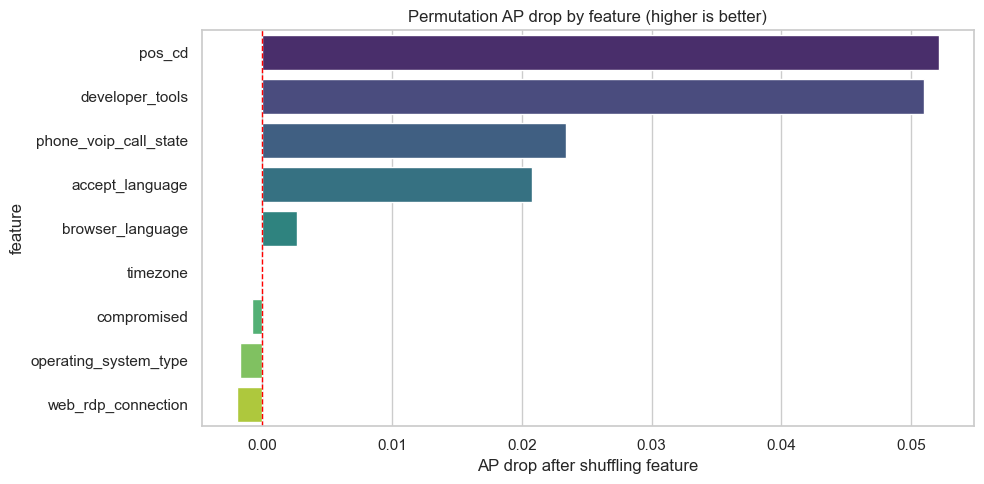

In [58]:
# График 1: реальный вклад фичи в AP
plt.figure(figsize=(10, 5))
sns.barplot(data=report_sorted, x='ap_drop', y='feature', palette='viridis')
plt.axvline(0.0, color='red', linestyle='--', linewidth=1)
plt.title('Permutation AP drop by feature (higher is better)')
plt.xlabel('AP drop after shuffling feature')
plt.ylabel('feature')
plt.tight_layout()
plt.show()


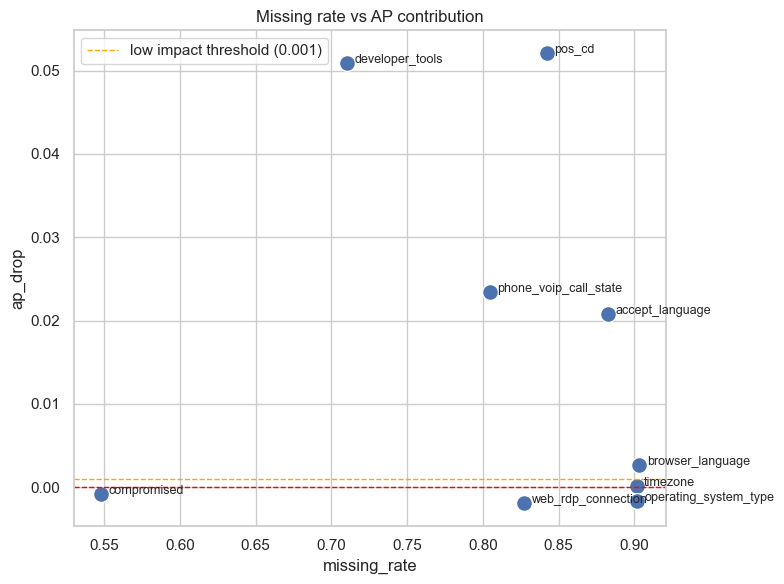

In [59]:
# График 2: пропуски vs полезность
plt.figure(figsize=(8, 6))
sns.scatterplot(data=report_sorted, x='missing_rate', y='ap_drop', s=130)
for _, r in report_sorted.iterrows():
    plt.text(r['missing_rate'] + 0.005, r['ap_drop'], r['feature'], fontsize=9)

plt.axhline(0.001, color='orange', linestyle='--', linewidth=1, label='low impact threshold (0.001)')
plt.axhline(0.0, color='red', linestyle='--', linewidth=1)
plt.title('Missing rate vs AP contribution')
plt.xlabel('missing_rate')
plt.ylabel('ap_drop')
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
# Таблица решений: что делаем с фичами прямо сейчас
# Правила можно менять, но это хороший практичный старт.

def feature_action(row):
    f = row['feature']
    ap = row['ap_drop']

    if f == 'accept_language':
        return 'KEEP + build accept_lang_base (ru/en/other/missing/star)'
    if f == 'browser_language':
        return 'KEEP_SIMPLE: browser_not_available flag + optional small bucket'
    if f == 'compromised':
        return 'KEEP_SIMPLE: bin(>0), plus compromised_not_01 flag'

    if ap >= 0.01:
        return 'KEEP_MAIN'
    if ap >= 0.001:
        return 'KEEP_SIMPLE'
    return 'DROP_OR_LOW_PRIORITY'

feature_plan = report_sorted[['feature', 'missing_rate', 'n_unique', 'fi', 'ap_drop']].copy()
feature_plan['action'] = feature_plan.apply(feature_action, axis=1)
feature_plan


,feature,missing_rate,n_unique,fi,ap_drop,action
0,pos_cd,0.842327,14,44.456061,0.052120,KEEP_MAIN
1,developer_tools,0.710310,3,3.883363,0.050948,KEEP_MAIN
2,phone_voip_call_state,0.804724,3,18.083395,0.023405,KEEP_MAIN
3,accept_language,0.882678,39,11.478812,0.020763,KEEP + build accept_lang_base (ru/en/other/mis...
4,browser_language,0.903346,2,7.536629,0.002683,KEEP_SIMPLE: browser_not_available flag + opti...
5,timezone,0.901581,37,3.306835,0.000111,DROP_OR_LOW_PRIORITY
6,compromised,0.547546,3,1.173896,-0.000760,"KEEP_SIMPLE: bin(>0), plus compromised_not_01 ..."
7,operating_system_type,0.902124,9,7.143580,-0.001705,DROP_OR_LOW_PRIORITY
8,web_rdp_connection,0.827394,3,2.937429,-0.001947,DROP_OR_LOW_PRIORITY


### Про log/scaler для CatBoost

Для **категориальных** фич в CatBoost:
- `Scaler` не нужен.
- `Log` не нужен.

Для **числовых** фич (это уже блок твоего друга):
- `Scaler` обычно тоже не нужен для CatBoost.
- `log1p` может помочь только для сильно скошенных числовых (`operaton_amt`), и это нужно проверять на CV.


## New Features From 9 Categorical Columns

Ниже блок, который:
- создает новые фичи из твоих 9 колонок;
- рисует графики влияния на target;
- сравнивает baseline vs engineered;
- автоматически делит новые фичи на `KEEP` и `LOW_PRIORITY`.


In [63]:
# Готовим рабочий датасет для анализа влияния
work_eng = df[df['target'].notna()].copy()
work_eng['target_bin'] = np.where(work_eng['target'].eq(1), 1, 0).astype('int8')

MISSING = '__MISSING__'
OTHER = '__OTHER__'


def topk_bucket(series, k=10):
    s = series.fillna(MISSING).astype(str)
    top = s.value_counts(dropna=False).head(k).index
    return np.where(s.isin(top), s, OTHER)


def parse_accept_lang(x):
    if pd.isna(x):
        return MISSING
    s = str(x).strip().lower()
    if s == '*':
        return '__STAR__'
    first = s.split(',')[0].split(';')[0].strip()
    base = first.split('-')[0].strip()
    return base if base else MISSING


def parse_browser_lang(x):
    if pd.isna(x):
        return MISSING
    s = str(x).strip().lower()
    if 'not available' in s:
        return 'not_available'
    first = s.split(',')[0].split(';')[0].strip()
    base = first.split('-')[0].strip()
    return base if base else MISSING

# Базовые подготовленные фичи
work_eng['accept_lang_base'] = work_eng['accept_language'].map(parse_accept_lang)
work_eng['accept_lang_grp'] = topk_bucket(work_eng['accept_lang_base'], k=10)

work_eng['browser_lang_base'] = work_eng['browser_language'].map(parse_browser_lang)
work_eng['browser_not_available'] = np.where(work_eng['browser_lang_base'].eq('not_available'), 1, 0).astype('int8')
work_eng['browser_lang_grp'] = topk_bucket(work_eng['browser_lang_base'], k=5)

# Риск-флаги
for c in ['developer_tools', 'phone_voip_call_state', 'web_rdp_connection', 'compromised']:
    work_eng[c + '_num'] = pd.to_numeric(work_eng[c], errors='coerce')

work_eng['developer_tools_bin'] = np.where(work_eng['developer_tools_num'].eq(1), 1, 0).astype('int8')
work_eng['phone_voip_call_state_bin'] = np.where(work_eng['phone_voip_call_state_num'].eq(1), 1, 0).astype('int8')
work_eng['web_rdp_connection_bin'] = np.where(work_eng['web_rdp_connection_num'].eq(1), 1, 0).astype('int8')
work_eng['compromised_bin'] = np.where(work_eng['compromised_num'].fillna(0) > 0, 1, 0).astype('int8')
work_eng['compromised_not_01'] = (
    (~work_eng['compromised_num'].isna()) & (~work_eng['compromised_num'].isin([0, 1]))
).astype('int8')

work_eng['risk_flags_sum'] = (
    work_eng['developer_tools_bin'].fillna(0)
    + work_eng['phone_voip_call_state_bin'].fillna(0)
    + work_eng['web_rdp_connection_bin'].fillna(0)
    + work_eng['compromised_bin'].fillna(0)
).astype('int8')
work_eng['any_risk_flag'] = np.where(work_eng['risk_flags_sum'] > 0, 1, 0).astype('int8')

# Missingness и кроссы
work_eng['n_missing_cat9'] = work_eng[cat_cols].isna().sum(axis=1).fillna(0).astype('int8')
work_eng['timezone_grp'] = topk_bucket(work_eng['timezone'].astype('string').fillna(MISSING), k=20)
work_eng['pos_cd_grp'] = topk_bucket(work_eng['pos_cd'].astype('string').fillna(MISSING), k=20)
work_eng['os_type_grp'] = topk_bucket(work_eng['operating_system_type'].astype('string').fillna(MISSING), k=10)

_acc = work_eng['accept_lang_base'].fillna(MISSING)
_br = work_eng['browser_lang_base'].fillna(MISSING)
work_eng['lang_mismatch'] = np.where(((_acc != _br) & (_acc != MISSING) & (_br != MISSING)), 1, 0).astype('int8')

work_eng['os_tz_pair'] = (
    work_eng['os_type_grp'].astype(str) + '__' + work_eng['timezone_grp'].astype(str)
)
work_eng['accept_browser_pair'] = (
    work_eng['accept_lang_grp'].astype(str) + '__' + work_eng['browser_lang_grp'].astype(str)
)

candidate_cat_features = [
    'accept_lang_grp', 'browser_lang_grp', 'timezone_grp', 'pos_cd_grp',
    'os_type_grp', 'os_tz_pair', 'accept_browser_pair'
]

candidate_num_features = [
    'browser_not_available', 'developer_tools_bin', 'phone_voip_call_state_bin',
    'web_rdp_connection_bin', 'compromised_bin', 'compromised_not_01',
    'risk_flags_sum', 'any_risk_flag', 'n_missing_cat9', 'lang_mismatch'
]

print('work_eng shape:', work_eng.shape)
print('candidate_cat_features:', candidate_cat_features)
print('candidate_num_features:', candidate_num_features)


ValueError: cannot convert NA to integer

In [ ]:
# Графики: как новые категориальные фичи связаны с target

def plot_cat_target_rate(data, col, target='target_bin', min_count=100, top_n=20):
    s = data[col].fillna(MISSING).astype(str)
    tmp = pd.DataFrame({'cat': s, target: data[target]})
    stat = tmp.groupby('cat')[target].agg(['count', 'mean']).rename(columns={'mean': 'target_rate'})
    stat = stat[stat['count'] >= min_count].sort_values('count', ascending=False).head(top_n)

    print(f'\n=== {col} ===')
    display(stat.sort_values('target_rate', ascending=False).head(20))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(data=stat.reset_index(), y='cat', x='count', ax=axes[0], color='#4C78A8')
    axes[0].set_title(f'{col}: count')
    sns.barplot(data=stat.sort_values('target_rate', ascending=False).reset_index(), y='cat', x='target_rate', ax=axes[1], color='#F58518')
    axes[1].set_title(f'{col}: target_rate')
    plt.tight_layout()
    plt.show()

for f in ['accept_lang_grp', 'browser_lang_grp', 'timezone_grp', 'pos_cd_grp', 'os_type_grp']:
    plot_cat_target_rate(work_eng, f, min_count=80, top_n=15)


In [ ]:
# Графики: числовые engineered-фичи vs target (через средний target_rate)

def plot_binary_rate(data, col, target='target_bin'):
    stat = data.groupby(col)[target].agg(['count', 'mean']).rename(columns={'mean': 'target_rate'}).reset_index()
    print(f'\n=== {col} ===')
    display(stat)
    plt.figure(figsize=(6, 4))
    sns.barplot(data=stat, x=col, y='target_rate', color='#54A24B')
    plt.title(f'{col}: target_rate')
    plt.tight_layout()
    plt.show()

for f in ['browser_not_available', 'lang_mismatch', 'any_risk_flag', 'compromised_not_01']:
    plot_binary_rate(work_eng, f)

plt.figure(figsize=(7, 4))
rate_by_sum = work_eng.groupby('risk_flags_sum')['target_bin'].mean().reset_index(name='target_rate')
sns.lineplot(data=rate_by_sum, x='risk_flags_sum', y='target_rate', marker='o')
plt.title('risk_flags_sum vs target_rate')
plt.tight_layout()
plt.show()


In [ ]:
# CatBoost: baseline vs baseline+engineered
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier

base_features = list(cat_cols)
base_cat_features = list(cat_cols)

X_base = work_eng[base_features].copy()
for c in base_cat_features:
    X_base[c] = X_base[c].astype('string').fillna(MISSING).astype(str)

y = pd.to_numeric(work_eng['target_bin'], errors='coerce').fillna(0).astype('int8')

X_train_b, X_val_b, y_train, y_val = train_test_split(
    X_base, y, test_size=0.2, random_state=42, stratify=y
)

base_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='PRAUC',
    iterations=350,
    depth=8,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=False
)
base_model.fit(X_train_b, y_train, cat_features=base_cat_features, eval_set=(X_val_b, y_val), use_best_model=True)
base_ap = average_precision_score(y_val, base_model.predict_proba(X_val_b)[:, 1])

engineered_features = base_features + candidate_cat_features + candidate_num_features
engineered_cat_features = base_cat_features + candidate_cat_features

X_eng = work_eng[engineered_features].copy()
for c in engineered_cat_features:
    X_eng[c] = X_eng[c].astype('string').fillna(MISSING).astype(str)
for c in candidate_num_features:
    X_eng[c] = pd.to_numeric(X_eng[c], errors='coerce').fillna(0)

X_train_e, X_val_e, _, _ = train_test_split(
    X_eng, y, test_size=0.2, random_state=42, stratify=y
)

eng_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='PRAUC',
    iterations=350,
    depth=8,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=False
)
eng_model.fit(X_train_e, y_train, cat_features=engineered_cat_features, eval_set=(X_val_e, y_val), use_best_model=True)
eng_ap = average_precision_score(y_val, eng_model.predict_proba(X_val_e)[:, 1])

print('Baseline AP:', round(base_ap, 6))
print('Engineered AP:', round(eng_ap, 6))
print('Delta AP:', round(eng_ap - base_ap, 6))


In [ ]:
# Permutation AP-drop только для новых фич -> KEEP / LOW_PRIORITY
rng = np.random.default_rng(42)
base_pred_ap = average_precision_score(y_val, eng_model.predict_proba(X_val_e)[:, 1])

cand_rows = []
for col in candidate_cat_features + candidate_num_features:
    Xp = X_val_e.copy()
    Xp[col] = rng.permutation(Xp[col].values)
    ap = average_precision_score(y_val, eng_model.predict_proba(Xp)[:, 1])
    cand_rows.append({'feature': col, 'ap_drop': base_pred_ap - ap})

cand_report = pd.DataFrame(cand_rows).sort_values('ap_drop', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 7))
sns.barplot(data=cand_report, x='ap_drop', y='feature', palette='mako')
plt.axvline(0.001, color='orange', linestyle='--', linewidth=1, label='keep threshold 0.001')
plt.axvline(0.0, color='red', linestyle='--', linewidth=1)
plt.title('Engineered features: AP drop after shuffle')
plt.legend()
plt.tight_layout()
plt.show()

cand_report['action'] = np.where(cand_report['ap_drop'] >= 0.001, 'KEEP', 'LOW_PRIORITY')
display(cand_report)

keep_new = cand_report.loc[cand_report['action'] == 'KEEP', 'feature'].tolist()
low_new = cand_report.loc[cand_report['action'] == 'LOW_PRIORITY', 'feature'].tolist()

print('KEEP new features:', keep_new)
print('LOW_PRIORITY new features:', low_new)


### Что это показывает

- Если `Delta AP > 0` — новые фичи в среднем помогают.
- В `cand_report` оставляй `action=KEEP`.
- `LOW_PRIORITY` можно убрать из первой версии модели и вернуть позже, если нужен буст ансамбля.

Про CatBoost:
- Для категориальных фич не нужен scaler.
- Log-преобразование нужно только для числовых, и только если CV реально растет.
